In [87]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import(
    load_excel, 
    load_odin_as_ml_dataset, 
    plot_confusion_matrix, 
    make_ml_dataset, 
    run_binary_regression, 
    transport_modes, 
    trip_motives, 
    province_codes, 
    transport_mode_col, 
    IGNORE_RULES, 
    apply_ignore_rules,
    number_of_sub_trips_col,
    id_col
    )
run_ML = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
years = [2019, 2020, 2021, 2022, 2023]
dfs = []
for year in years:
    odin_excel_path = os.path.join(os.getcwd(), "data", "OdiN 2019-2023", f"OdiN {year}", f"ODiN{year}_Databestand.csv")
    if year in [2019, 2020]:
        odin_excel_path = odin_excel_path.replace("Databestand", "Databestand_v2.0")
    df = load_excel(odin_excel_path)
    # df = apply_ignore_rules(df, IGNORE_RULES)   # <<–– new line

    dfs.append(df[df[number_of_sub_trips_col] == 1])  # Filter for single sub-trips

df_all = pd.concat(dfs, ignore_index=True, join="inner")
# Convert 'ActDuur' to numeric, handling errors by coercing NaN to 0
df_all['ActDuur'] = pd.to_numeric(df_all['ActDuur'], errors='coerce').fillna(0)

Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV


In [3]:
df_all = apply_ignore_rules(df_all, IGNORE_RULES)  # Apply ignore rules after filtering

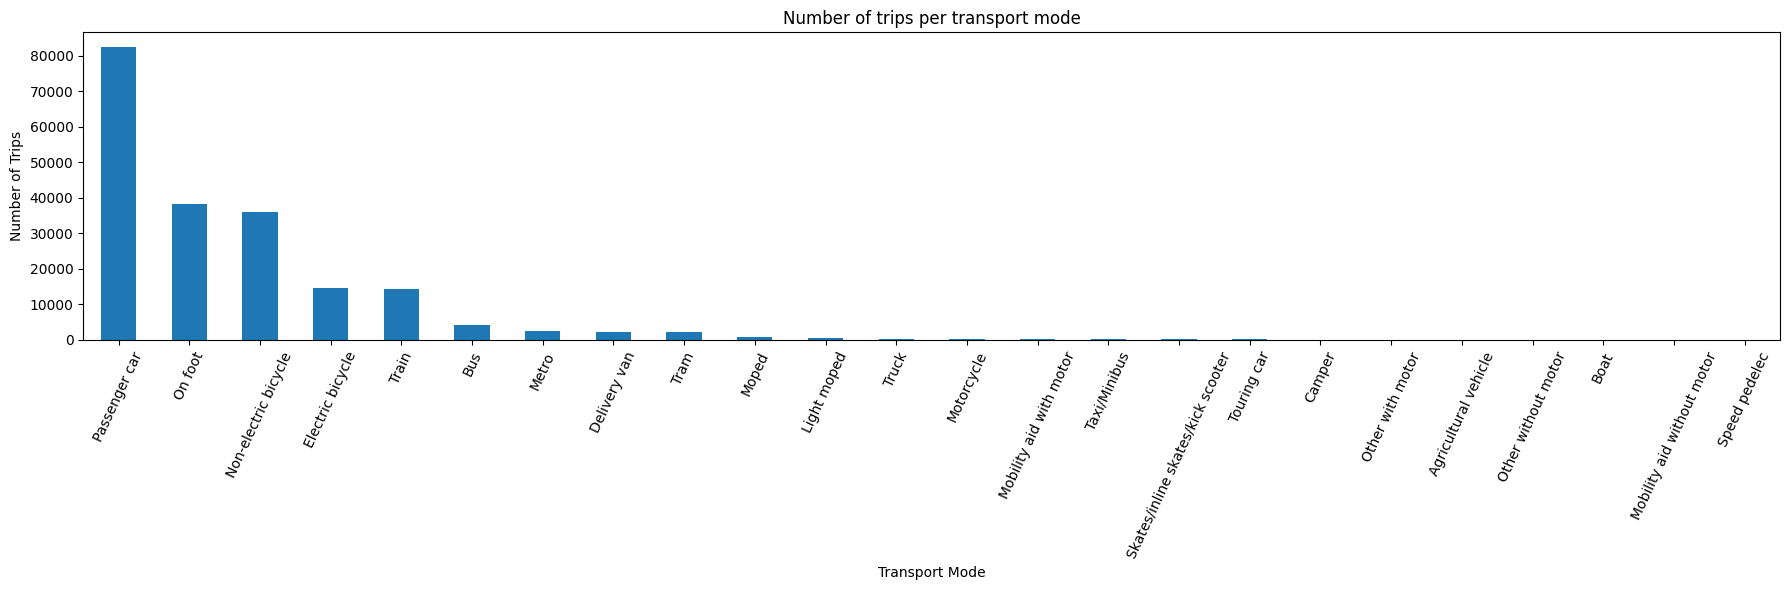

In [4]:
# Create a histogram for the number of trips for each transport mode and translate to 
ax = df[transport_mode_col].value_counts().plot(kind="bar", title="Number of trips per transport mode", figsize=(18, 6))

ax.set_xticklabels([transport_modes.get(int(float(label.get_text())), label.get_text()) for label in ax.get_xticklabels()], rotation=65)

plt.xlabel("Transport Mode")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.savefig("graphics/transport_modes_histogram.png", dpi=300)
plt.show()

Now a classifier that classifies what mode of transport was used

Common labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.4s finished


                                   precision    recall  f1-score   support

                    Passenger car       0.86      0.22      0.35     70667
                            Train       0.12      0.87      0.21       320
                              Bus       0.17      0.58      0.27       672
                             Tram       0.12      0.71      0.20       351
                            Metro       0.10      0.41      0.16       192
                    Speed pedelec       0.00      0.00      0.00         7
                 Electric bicycle       0.36      0.79      0.49     10326
             Non-electric bicycle       0.57      0.46      0.51     33505
                          On foot       0.82      0.45      0.58     34699
                      Touring car       0.02      0.17      0.03       119
                     Delivery van       0.10      0.33      0.16      2161
                            Truck       0.01      0.44      0.02        71
                        

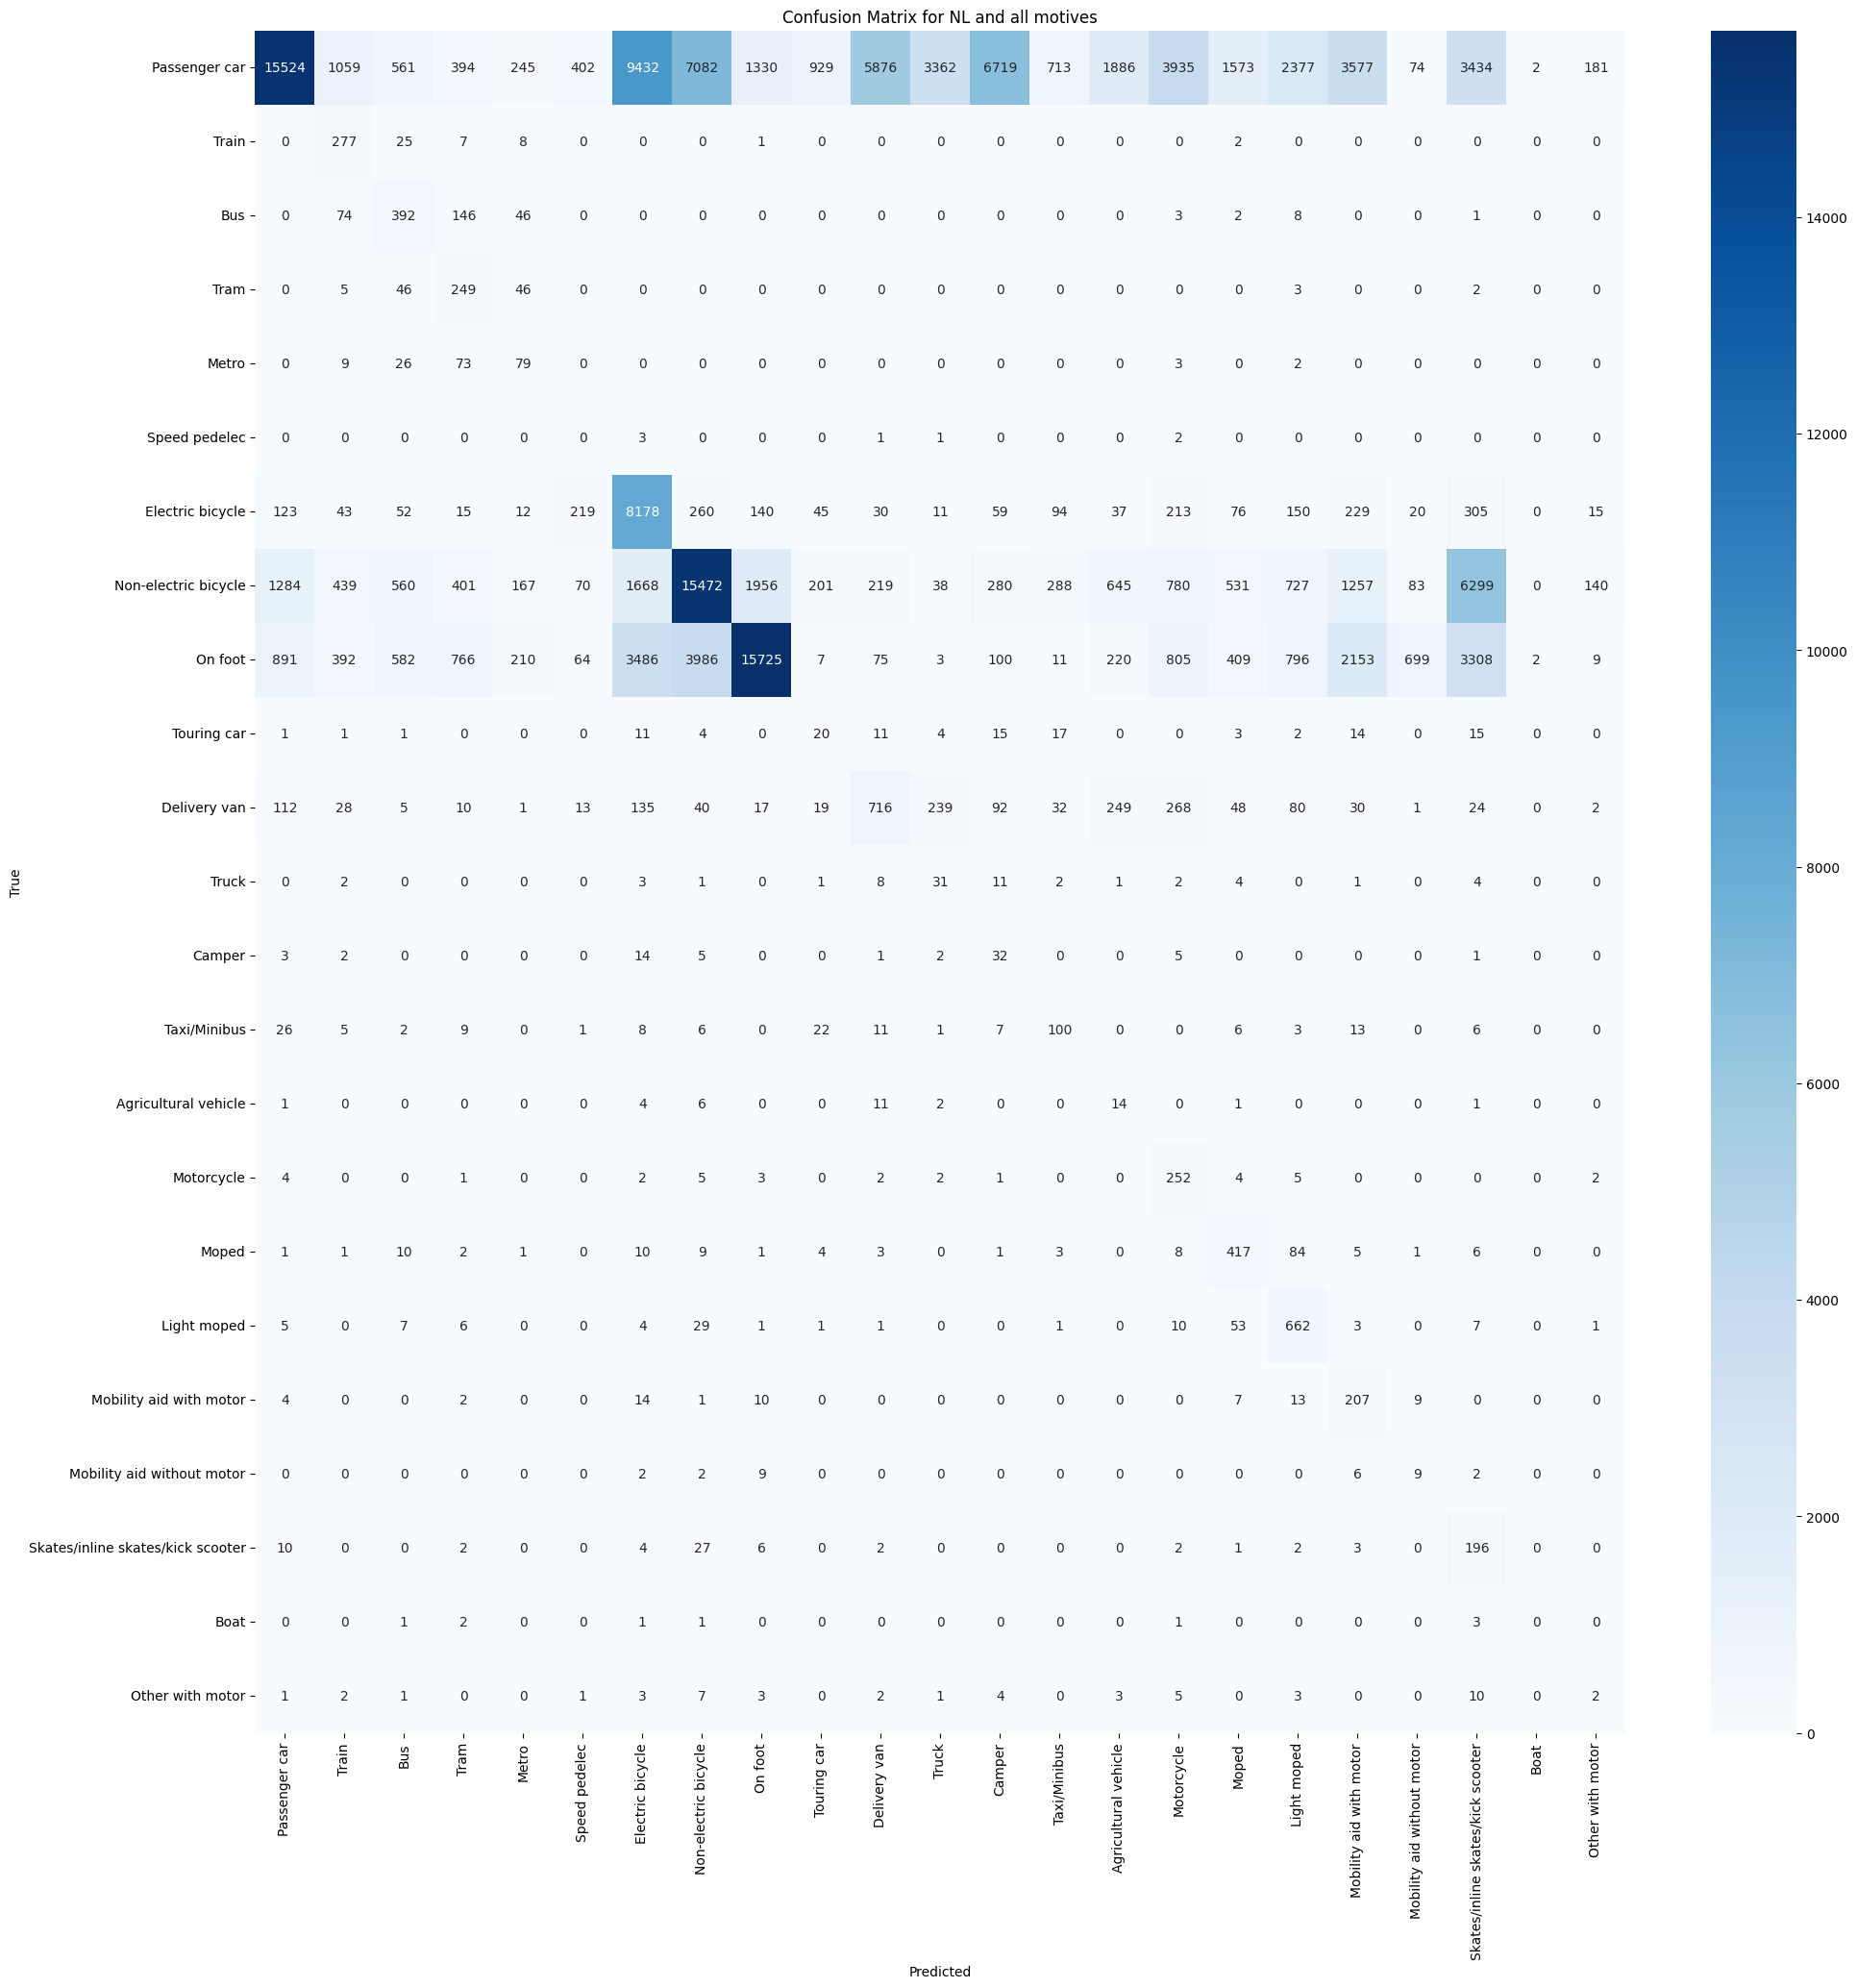

In [5]:
from codebase import (run_multiclass_classification,
                      distance_col, 
                      origin_col, 
                      province_codes, 
                      level_mapping_suffix, 
                      age_col, 
                      transport_mode_col, 
                      motive_col, 
                      urbanness_col,
                      categorical_cols)


df_multiclass = df_all[df_all[transport_mode_col] != df_all[transport_mode_col].max()]
motives=None
origins=None#[7, 8, ]
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_all, (X_train_all, _, _, _), accuracy = run_multiclass_classification(
    df_multiclass,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/full",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
    verbose=True,
)

In [6]:
def get_feature_importances(feature_importances, column_names, top_n_for_plot=100, savename=None):
    """
    Feature importances for multiclass classification.
    """
    importances = pd.Series(feature_importances, index=column_names)
    
    # Group by base feature name (e.g., col_1 from col_1.0, col_1.1)
    grouped = importances.groupby(lambda x: x.split('_')[0]).sum()
    top_features = grouped.sort_values(ascending=False)[:top_n_for_plot]
    num_features = len(grouped)
    num_plotted_features = min(num_features, top_n_for_plot)

    top_features.plot(kind="bar", figsize=(14, 6))
    plt.title(f"Top {num_plotted_features}/{num_features} Feature Importances for Multiclass Classification")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.xticks(rotation=65)
    if savename:
        plt.savefig(savename)
    plt.show()
    
    return grouped

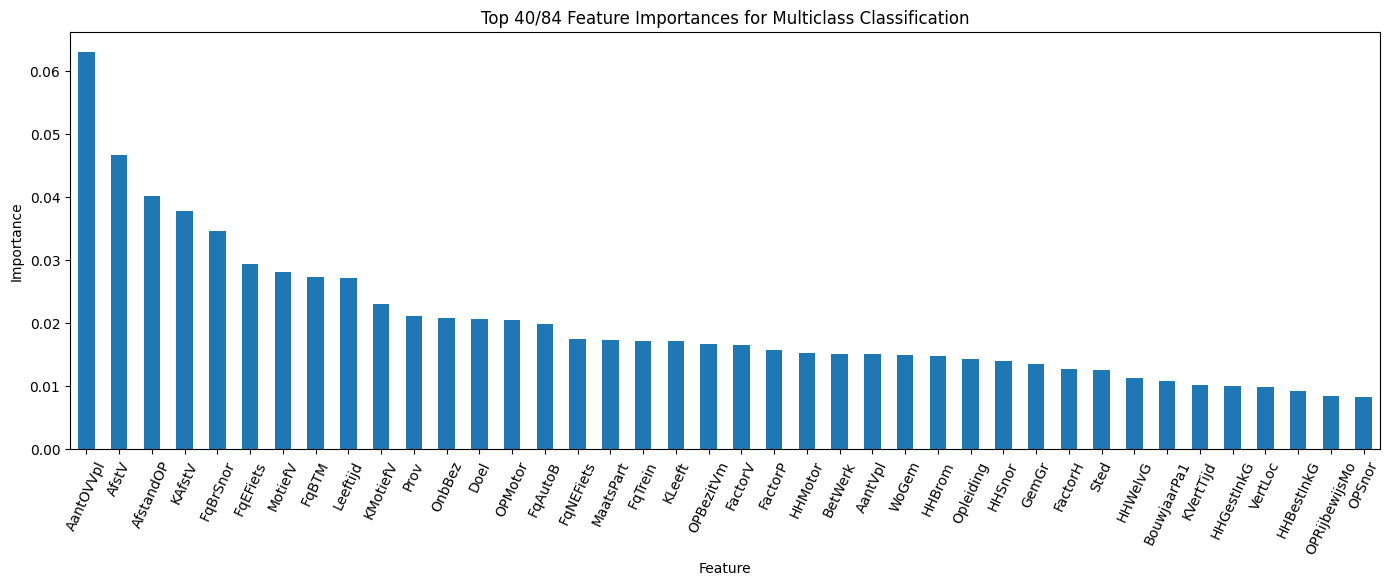

AantOVVpl    0.063119
AantSVpl     0.001902
AantVpl      0.015117
AardWerk     0.005080
ActDuur      0.006422
               ...   
Prov         0.021193
Sted         0.012654
VertLoc      0.009848
VolgWerk     0.005430
WoGem        0.014916
Length: 84, dtype: float64

In [7]:
get_feature_importances(pipeline_all["model"].feature_importances_, top_n_for_plot=40, column_names=X_train_all.columns, savename=f"graphics/classification_results/multiclass/feature_importances_all.png")

In [8]:
from codebase import urbanness_col, motive_col

age_range = (0, np.inf)
vehicles_to_include = [1, 7, 8, 9, ]

df_less_vehicles = df_multiclass[df_multiclass[transport_mode_col].isin(vehicles_to_include)]
df_less_vehicles: pd.DataFrame = df_less_vehicles[(df_less_vehicles[age_col] < age_range[1]) & (df_less_vehicles[age_col] > age_range[0])]

Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.72      0.80     70523
    Electric bicycle       0.40      0.91      0.56     10541
Non-electric bicycle       0.64      0.77      0.70     33669
             On foot       0.83      0.68      0.75     34802

            accuracy                           0.73    149535
           macro avg       0.69      0.77      0.70    149535
        weighted avg       0.79      0.73      0.75    149535



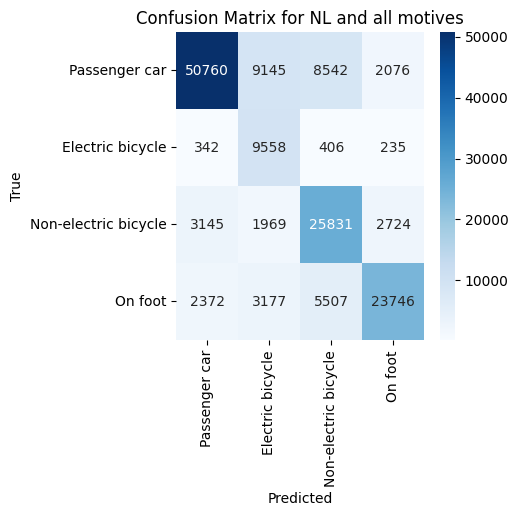

In [9]:
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_less, (X_train_less, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

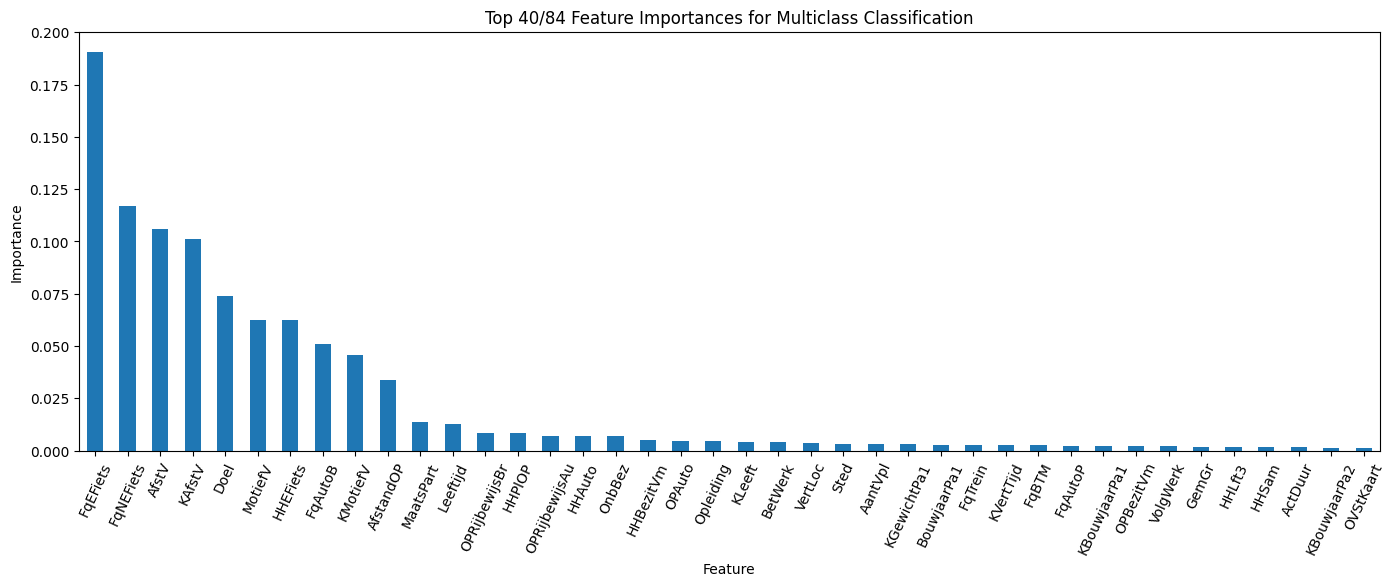

In [10]:
grouped_importances_less = get_feature_importances(pipeline_less["model"].feature_importances_, column_names=X_train_less.columns, top_n_for_plot=40, savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles.png")

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier


class SktorchNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[64], dtype=torch.float64):
        super(SktorchNN, self).__init__()
        layers = []
        for size in hidden_layers:
            layers.append(nn.Linear(input_dim, size, dtype=dtype))
            layers.append(nn.ReLU())
            input_dim = size
        layers.append(nn.Linear(size, output_dim, dtype=dtype))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [12]:
X_train_less.columns[np.where(X_train_less.isna().sum(axis=0))]

Index(['BetWerk', 'HHBestInkG', 'HHGestInkG', 'HHLaagInk', 'HHSocInk',
       'HHWelvG', 'HHAuto', 'HHAutoL', 'BouwjaarPa1', 'KBouwjaarPa1',
       'KGewichtPa1', 'BouwjaarPa2', 'KBouwjaarPa2', 'BouwjaarPaL',
       'KBouwjaarPaL', 'ByzAdr', 'ByzVvm', 'ByzTyd', 'ByzDuur', 'ByzRoute',
       'AfstandSOP', 'MeerWink'],
      dtype='object')

In [13]:
from codebase import run_multiclass_classification
from skorch.callbacks import Checkpoint

save_path = "neural_net_checkpoints"
os.makedirs(save_path, exist_ok=True)
checkpoint = Checkpoint(monitor='valid_loss_best', f_params='best_model.pt')
early_stopping = Checkpoint(monitor='valid_loss_best', f_patience=2, f_params='best_model.pt')
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

lr = 0.001
input_dim=X_train_less.shape[1]
output_dim=len(vehicles_to_include)
hidden_layers=[500, 200, 100]
max_epochs=5

net = NeuralNetClassifier(
    SktorchNN(input_dim=input_dim, output_dim=output_dim, hidden_layers=hidden_layers),
    max_epochs=max_epochs,
    lr=lr,
    batch_size=32,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    verbose=1,
    device=device,
    callbacks=[checkpoint, early_stopping],
)
if run_ML:
    pipeline_less, (X_train_less, _, _, _), accuracy = run_multiclass_classification(
        df_less_vehicles,
        test_size=0.2,
        model=net,
        destinations=None,
        origins=origins,
        location_level=location_level,
        categorical_features=categorical_cols,
        motives=motives,
        plot=True,
        savename=f"graphics/classification_results/multiclass/neural_net/less_vehicles",
        plot_title=f"Confusion Matrix for Neural Network on {origin_str} and {motive_str}",
        y_translation={val: order for order, val in enumerate(vehicles_to_include)},
    )

Using device: cuda


Now keep the top N

In [14]:
"Hvm" in df_less_vehicles.columns

True

Keeping 86 columns after dropping 116 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.72      0.80     70523
    Electric bicycle       0.40      0.91      0.56     10541
Non-electric bicycle       0.64      0.77      0.70     33669
             On foot       0.83      0.68      0.75     34802

            accuracy                           0.73    149535
           macro avg       0.69      0.77      0.70    149535
        weighted avg       0.79      0.73      0.75    149535



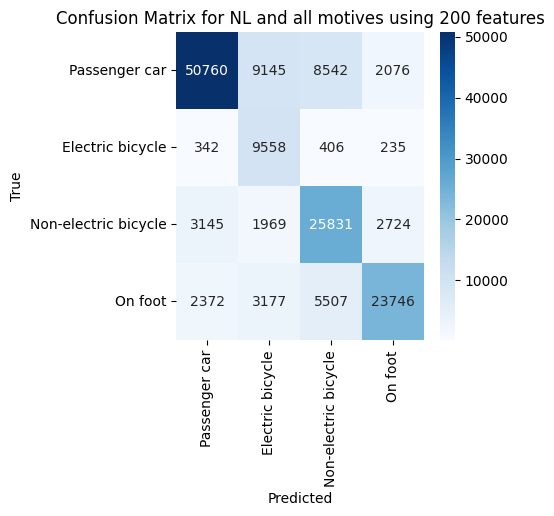

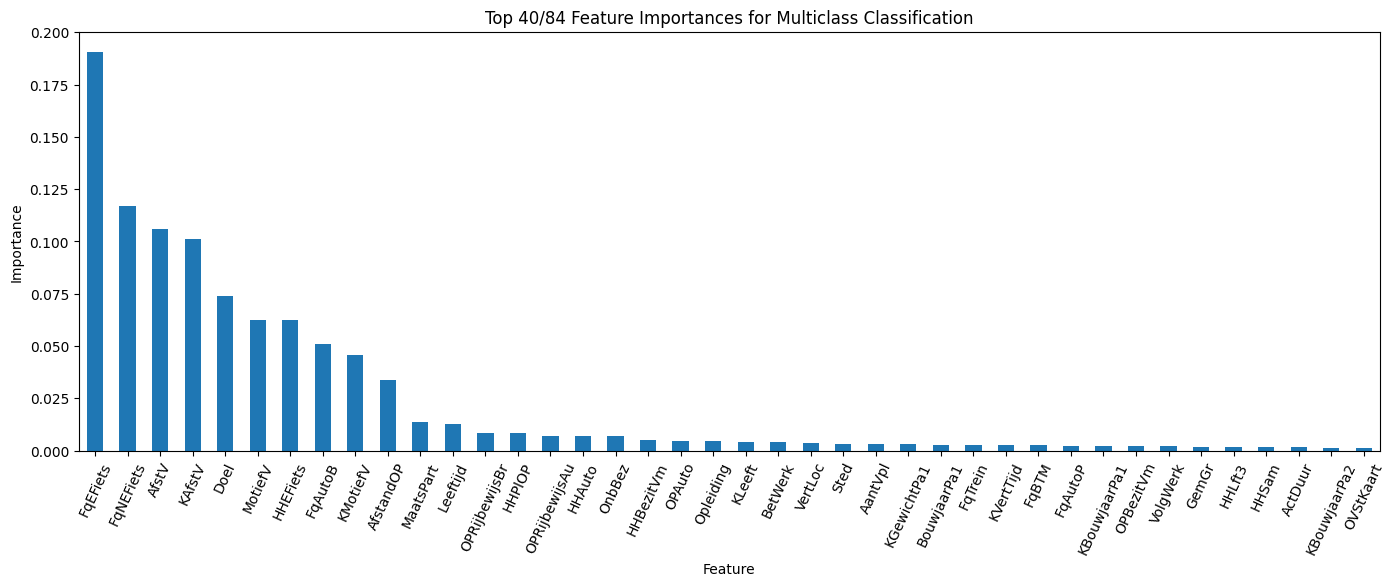

Keeping 86 columns after dropping 116 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.72      0.80     70523
    Electric bicycle       0.40      0.91      0.56     10541
Non-electric bicycle       0.64      0.77      0.70     33669
             On foot       0.83      0.68      0.75     34802

            accuracy                           0.73    149535
           macro avg       0.69      0.77      0.70    149535
        weighted avg       0.79      0.73      0.75    149535



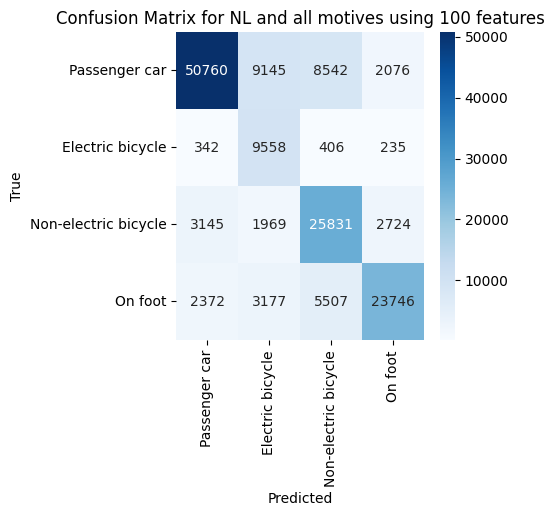

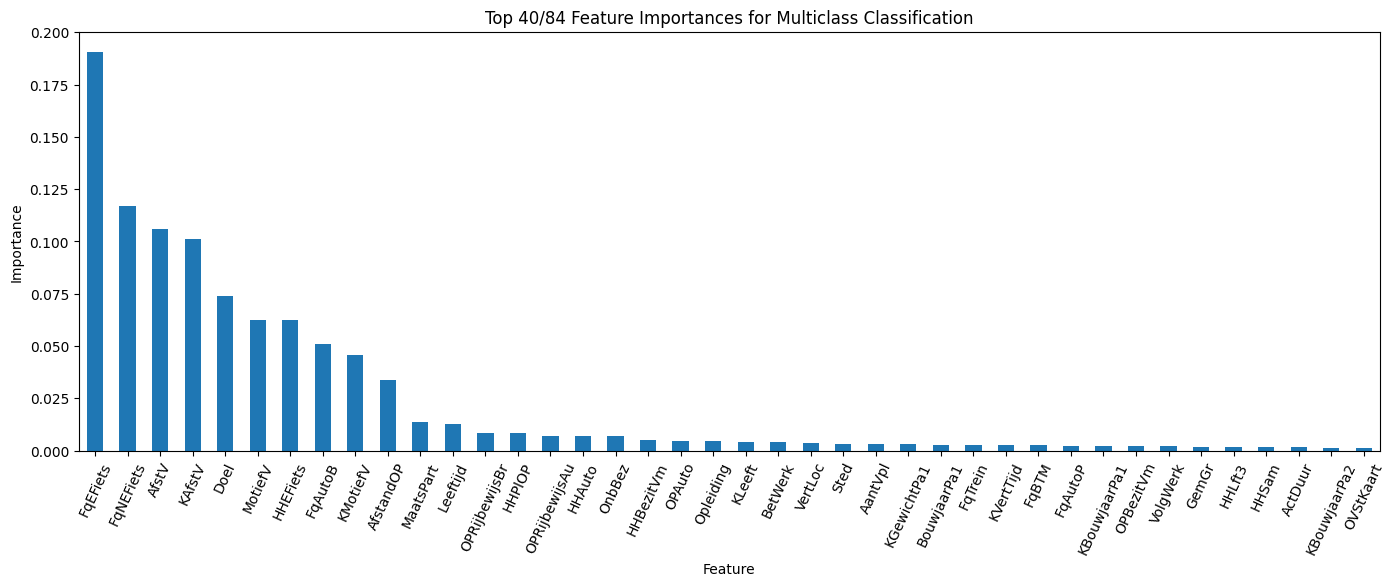

Keeping 52 columns after dropping 150 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.72      0.80     70523
    Electric bicycle       0.41      0.90      0.56     10541
Non-electric bicycle       0.65      0.77      0.70     33669
             On foot       0.82      0.70      0.76     34802

            accuracy                           0.74    149535
           macro avg       0.70      0.77      0.71    149535
        weighted avg       0.79      0.74      0.75    149535



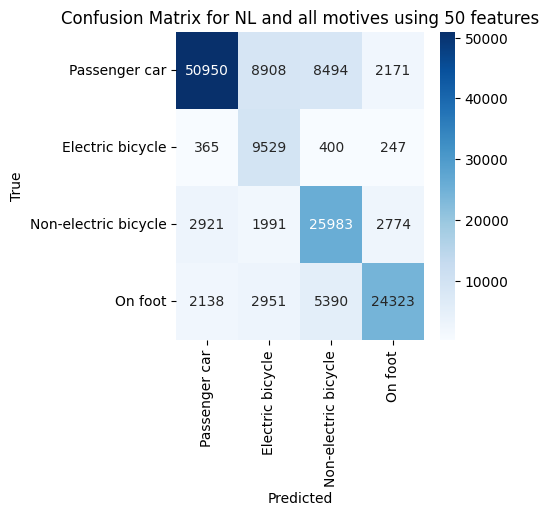

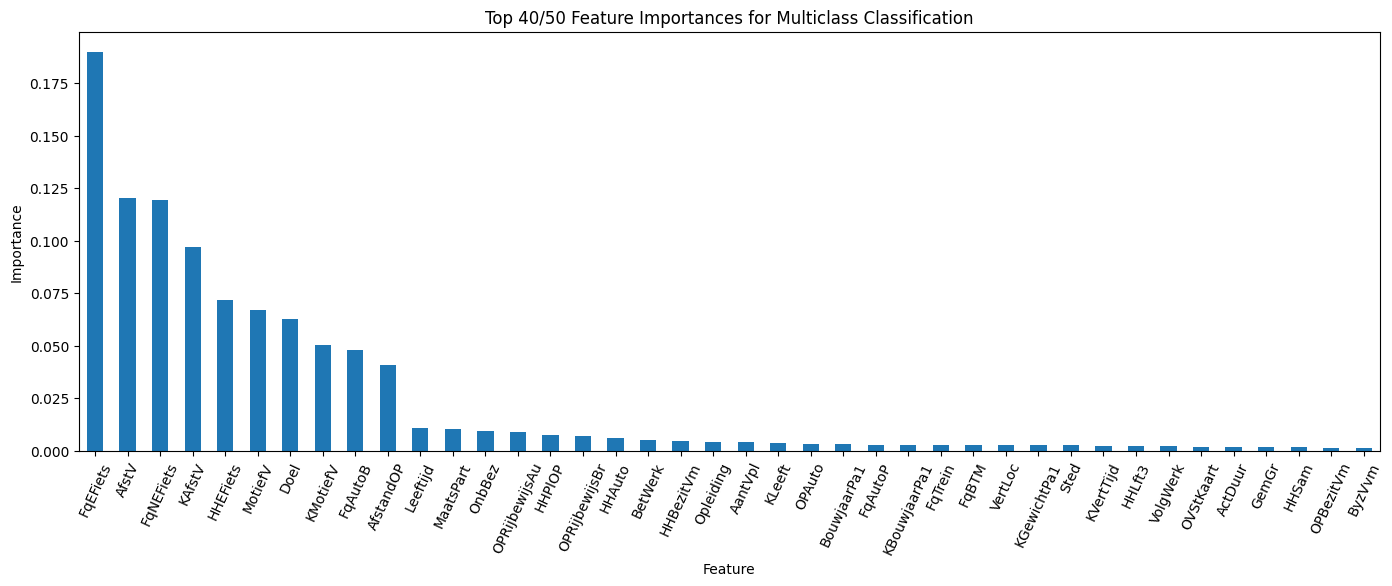

Keeping 27 columns after dropping 175 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.91      0.72      0.81     70523
    Electric bicycle       0.42      0.90      0.57     10541
Non-electric bicycle       0.65      0.78      0.71     33669
             On foot       0.82      0.71      0.76     34802

            accuracy                           0.75    149535
           macro avg       0.70      0.78      0.71    149535
        weighted avg       0.80      0.75      0.76    149535



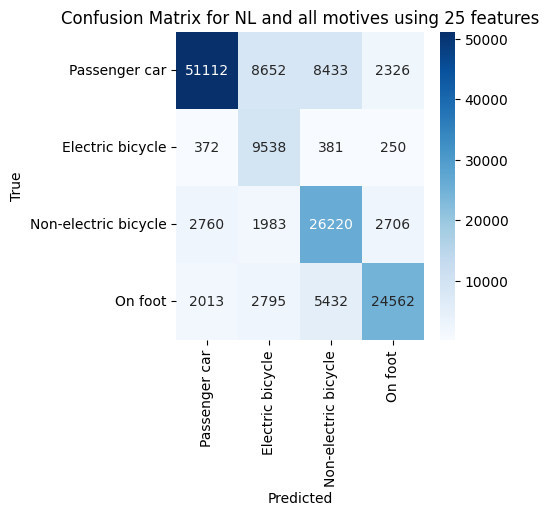

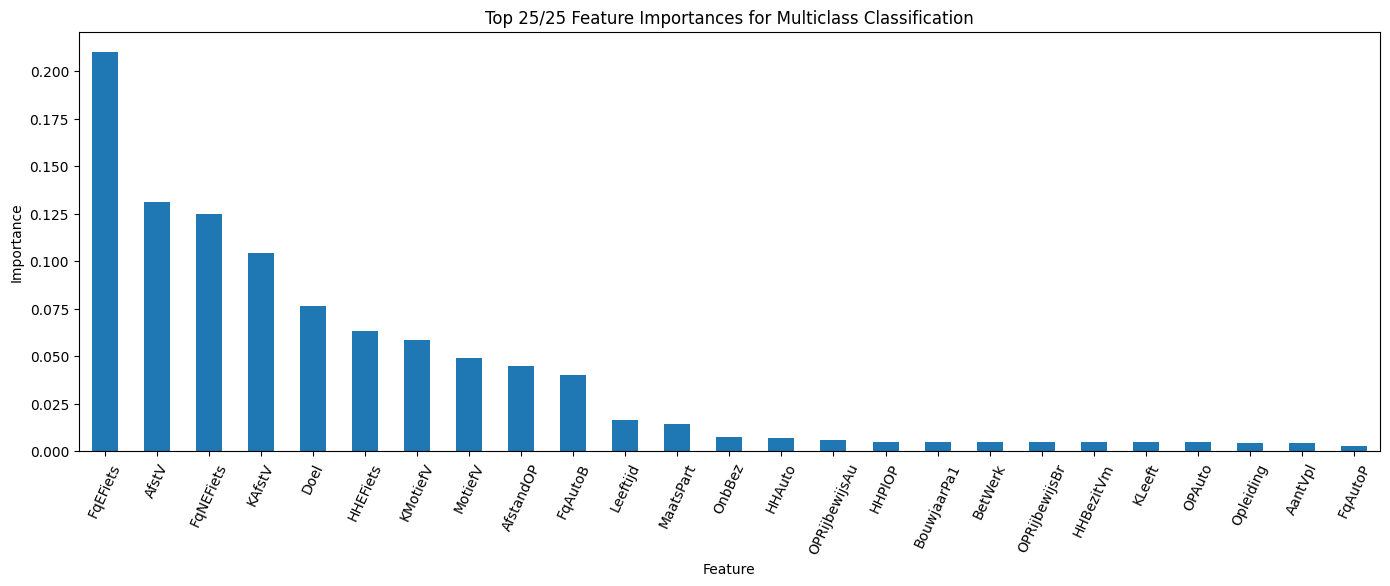

Keeping 17 columns after dropping 185 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.92      0.71      0.80     70523
    Electric bicycle       0.42      0.90      0.57     10541
Non-electric bicycle       0.63      0.78      0.70     33669
             On foot       0.82      0.72      0.76     34802

            accuracy                           0.74    149535
           macro avg       0.70      0.78      0.71    149535
        weighted avg       0.79      0.74      0.75    149535



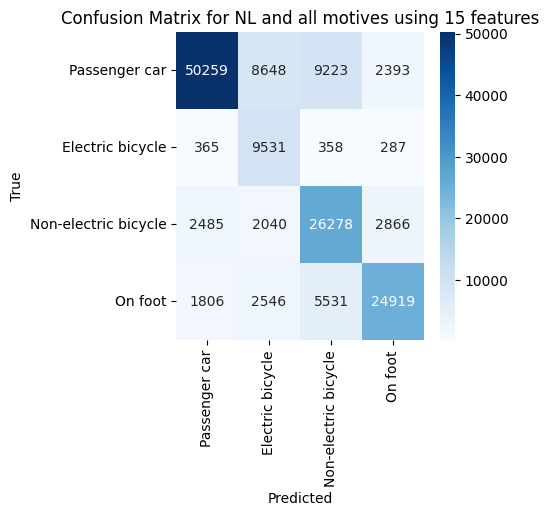

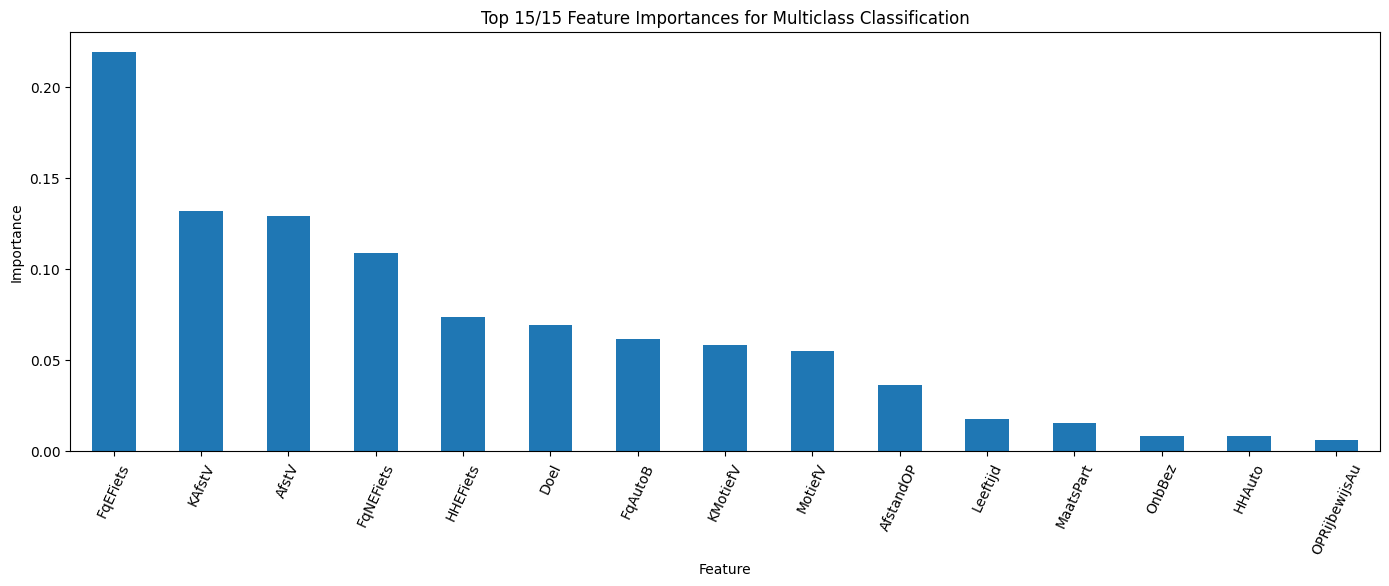

Keeping 12 columns after dropping 190 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.92      0.72      0.80     70523
    Electric bicycle       0.43      0.90      0.58     10541
Non-electric bicycle       0.64      0.79      0.71     33669
             On foot       0.81      0.72      0.76     34802

            accuracy                           0.75    149535
           macro avg       0.70      0.78      0.71    149535
        weighted avg       0.80      0.75      0.76    149535



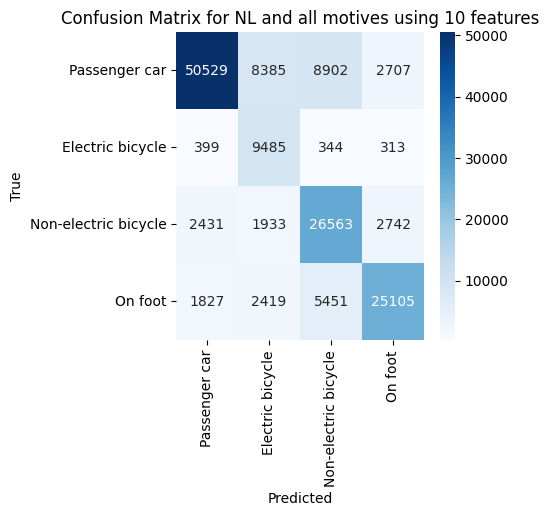

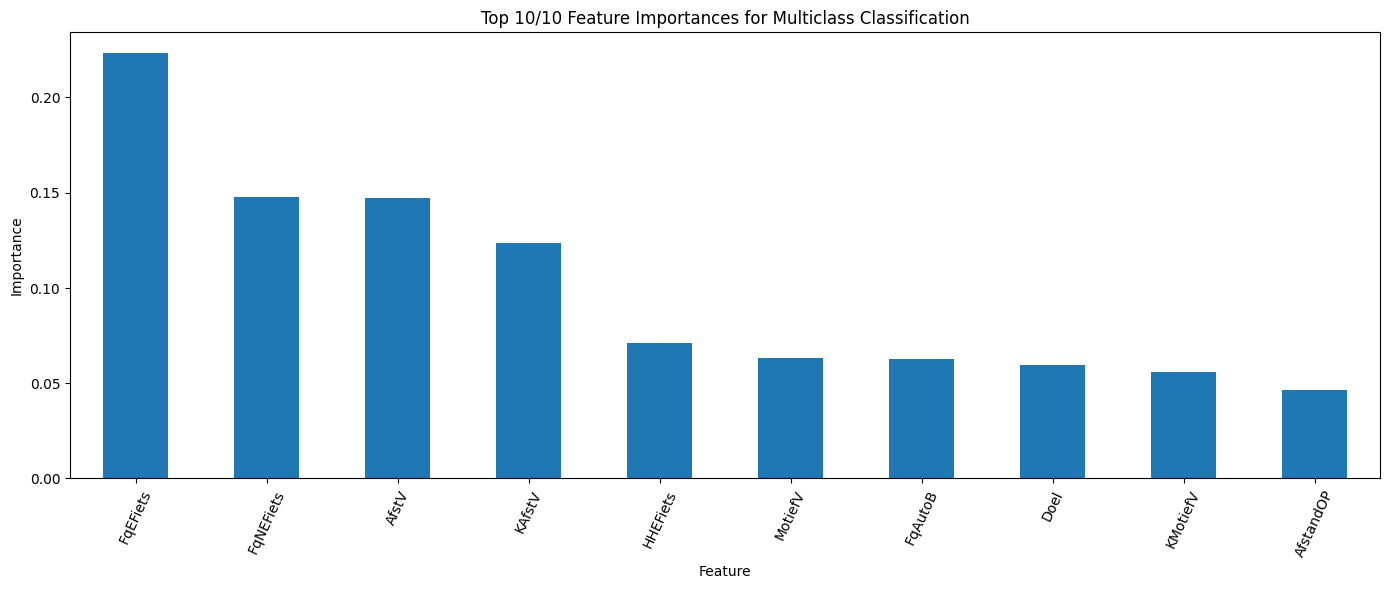

Keeping 10 columns after dropping 192 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.91      0.72      0.80     70523
    Electric bicycle       0.42      0.90      0.58     10541
Non-electric bicycle       0.66      0.77      0.71     33669
             On foot       0.80      0.73      0.76     34802

            accuracy                           0.75    149535
           macro avg       0.70      0.78      0.71    149535
        weighted avg       0.79      0.75      0.76    149535



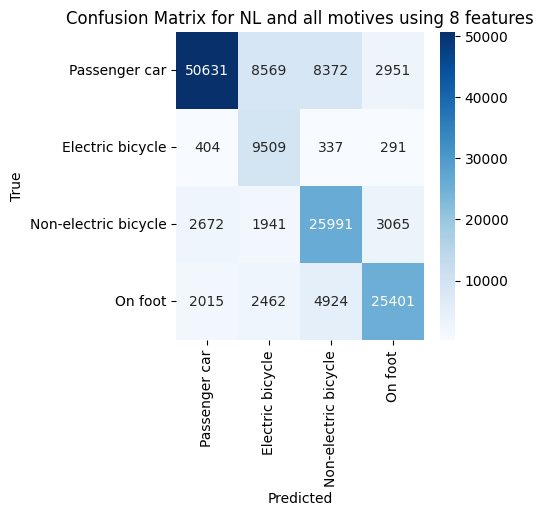

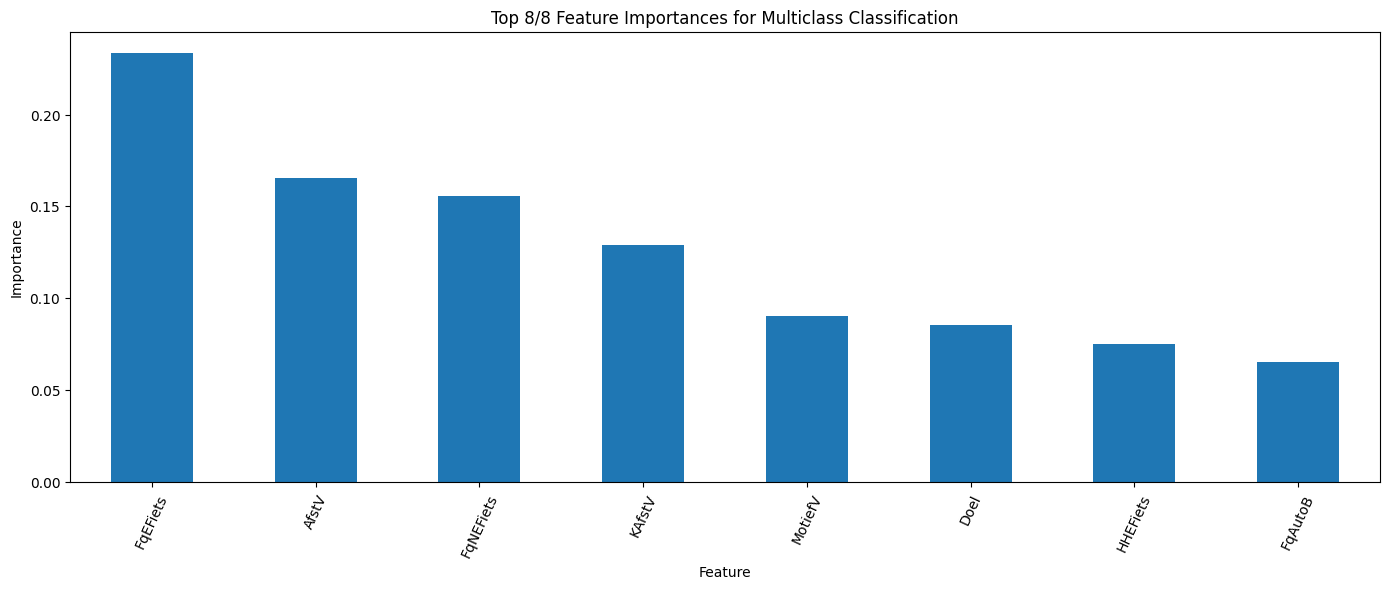

Keeping 7 columns after dropping 195 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.68      0.78     70523
    Electric bicycle       0.42      0.89      0.57     10541
Non-electric bicycle       0.63      0.79      0.70     33669
             On foot       0.79      0.72      0.75     34802

            accuracy                           0.73    149535
           macro avg       0.69      0.77      0.70    149535
        weighted avg       0.78      0.73      0.74    149535



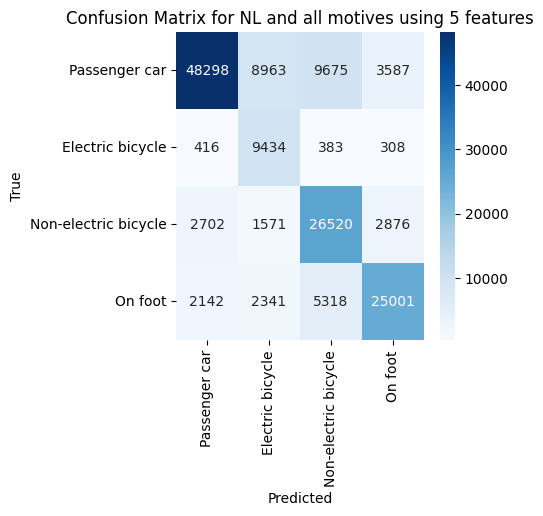

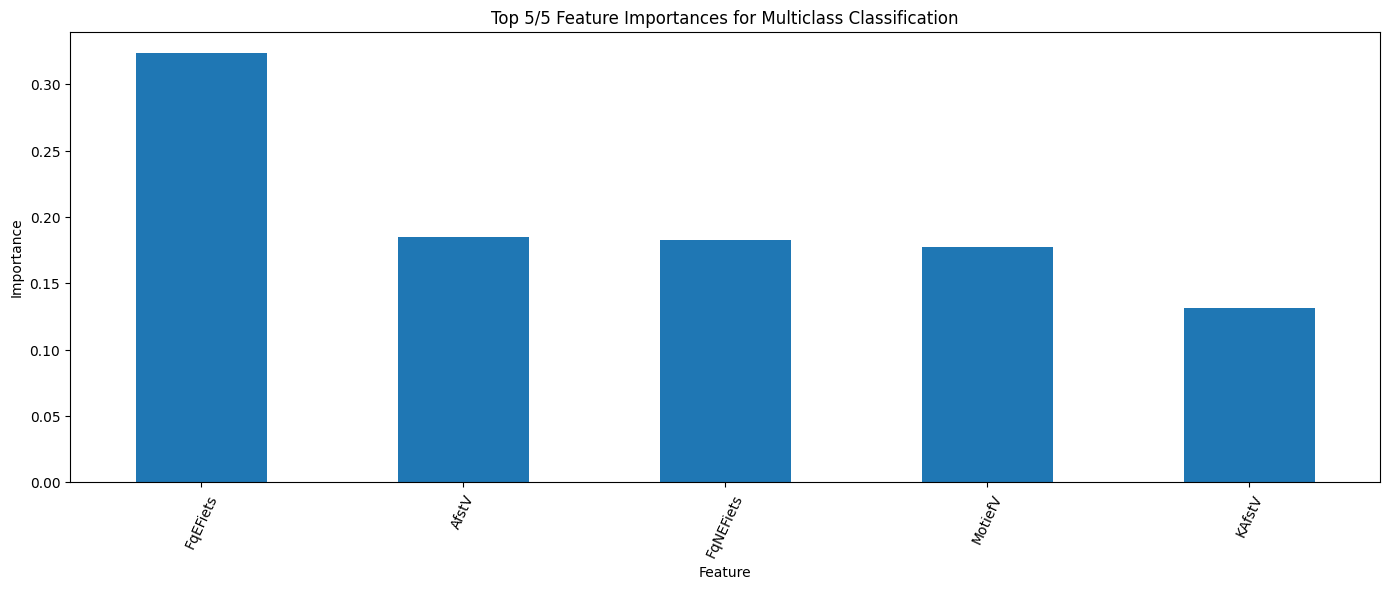

Keeping 6 columns after dropping 196 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.89      0.69      0.78     70523
    Electric bicycle       0.42      0.90      0.57     10541
Non-electric bicycle       0.65      0.77      0.70     33669
             On foot       0.77      0.73      0.75     34802

            accuracy                           0.73    149535
           macro avg       0.68      0.77      0.70    149535
        weighted avg       0.78      0.73      0.74    149535



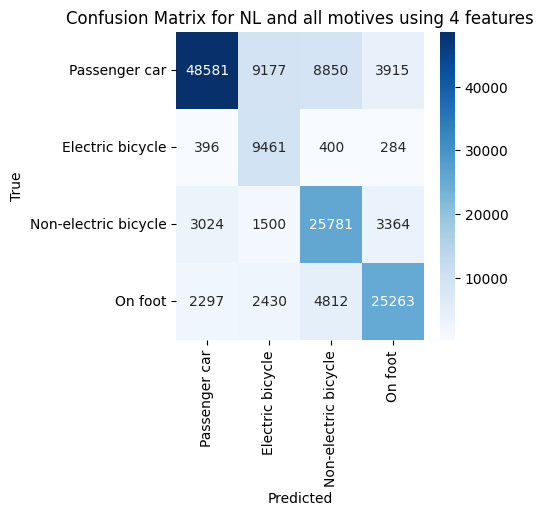

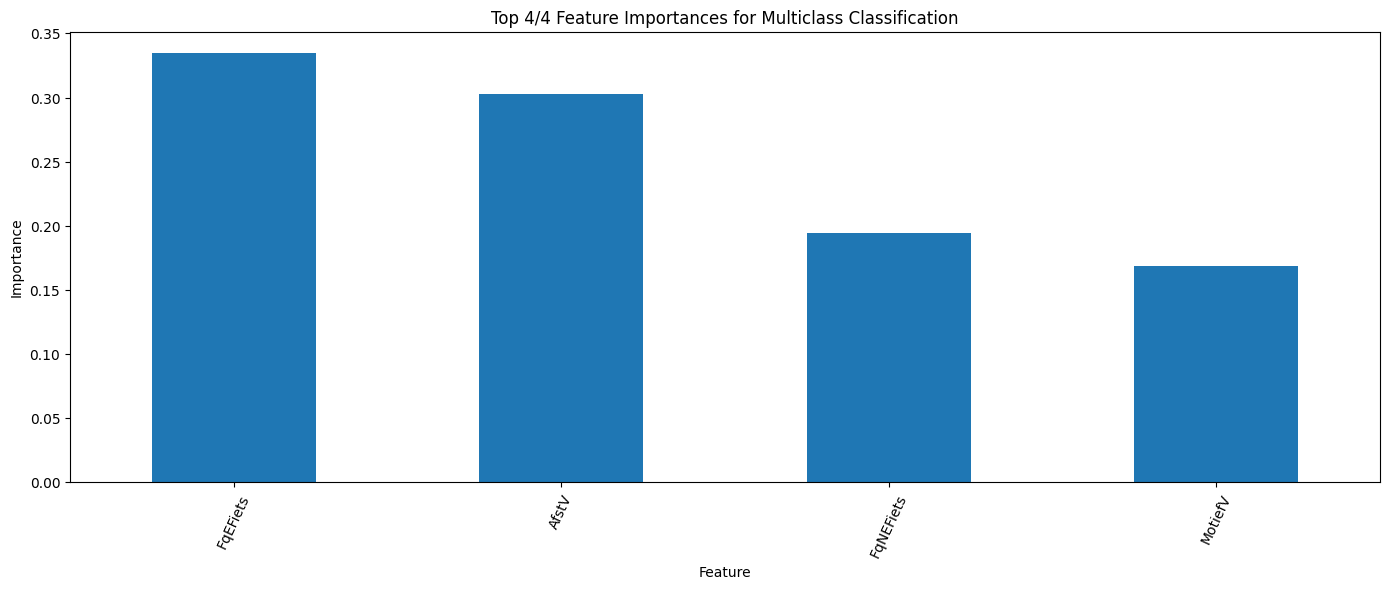

Keeping 5 columns after dropping 197 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.85      0.61      0.71     70523
    Electric bicycle       0.36      0.88      0.51     10541
Non-electric bicycle       0.58      0.77      0.66     33669
             On foot       0.61      0.49      0.55     34802

            accuracy                           0.64    149535
           macro avg       0.60      0.69      0.61    149535
        weighted avg       0.70      0.64      0.65    149535



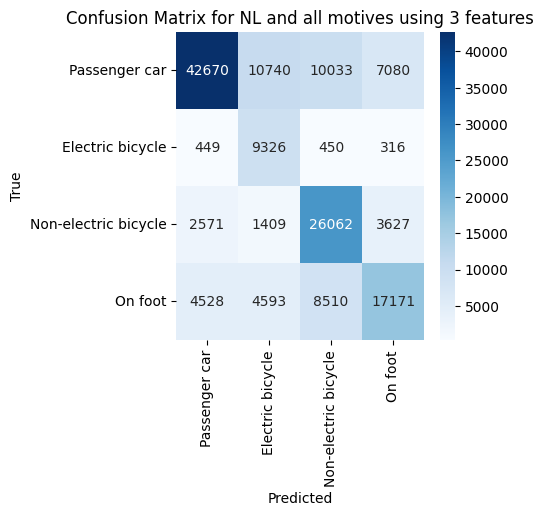

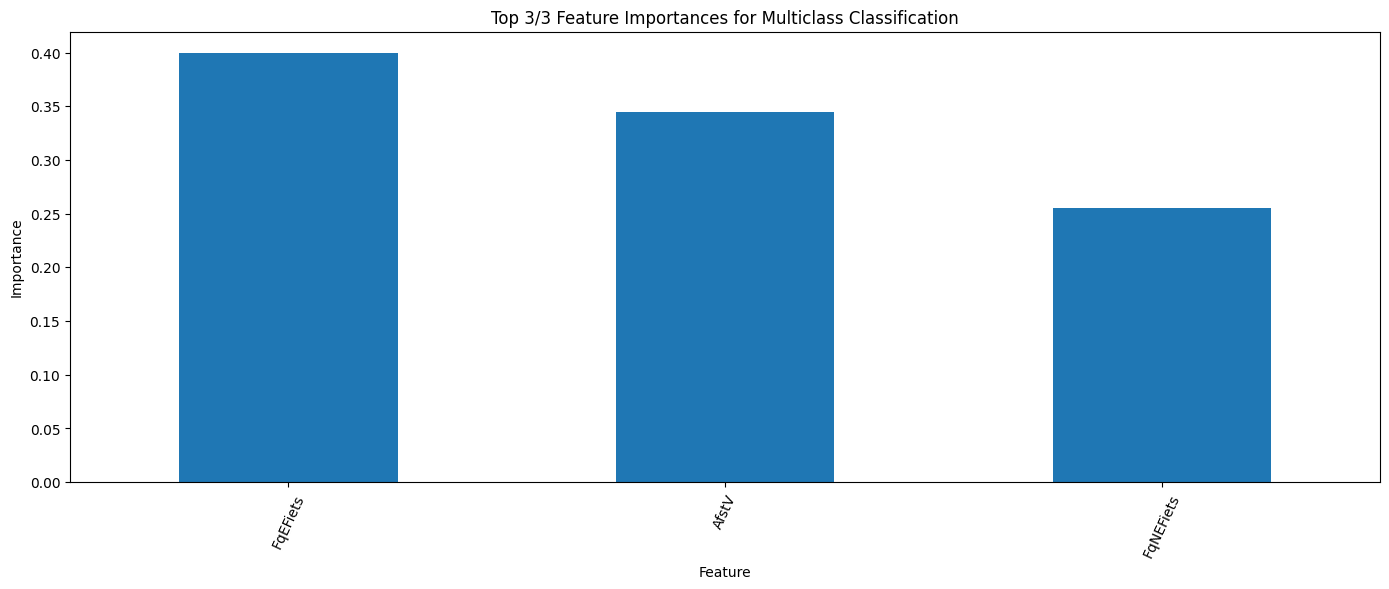

Keeping 4 columns after dropping 198 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.80      0.55      0.65     70523
    Electric bicycle       0.34      0.90      0.50     10541
Non-electric bicycle       0.40      0.65      0.50     33669
             On foot       0.68      0.37      0.48     34802

            accuracy                           0.55    149535
           macro avg       0.56      0.62      0.53    149535
        weighted avg       0.65      0.55      0.57    149535



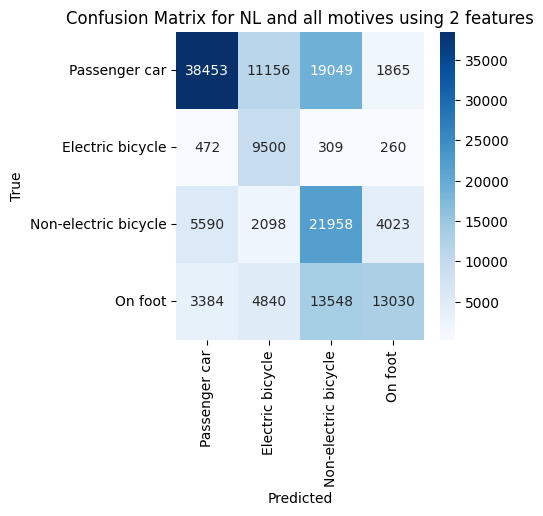

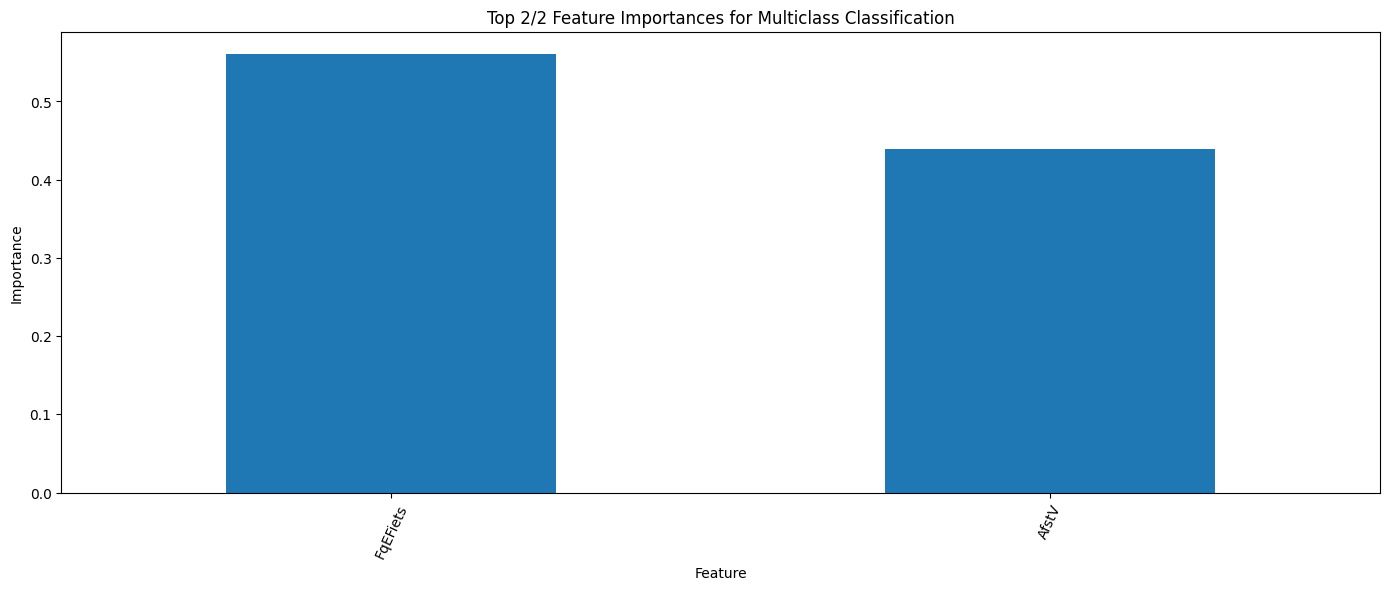

Keeping 3 columns after dropping 199 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'AfstV'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set

                      precision    recall  f1-score   support

       Passenger car       0.57      0.12      0.20     70523
    Electric bicycle       0.31      0.93      0.47     10541
Non-electric bicycle       0.28      0.85      0.42     33669
             On foot       0.00      0.00      0.00     34802

            accuracy                           0.31    149535
           macro avg       0.29      0.47      0.27    149535
        weighted avg       0.35      0.31      0.22    149535



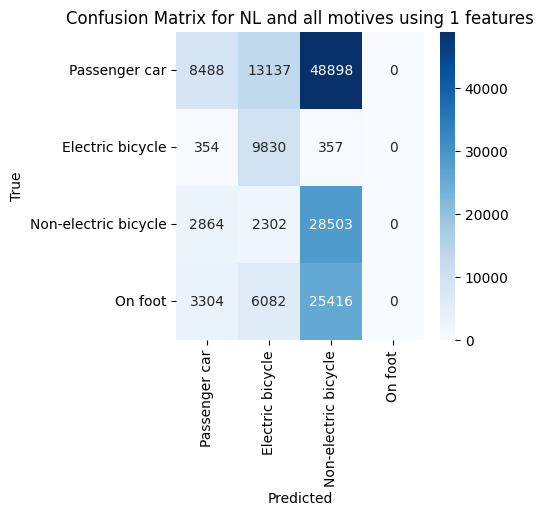

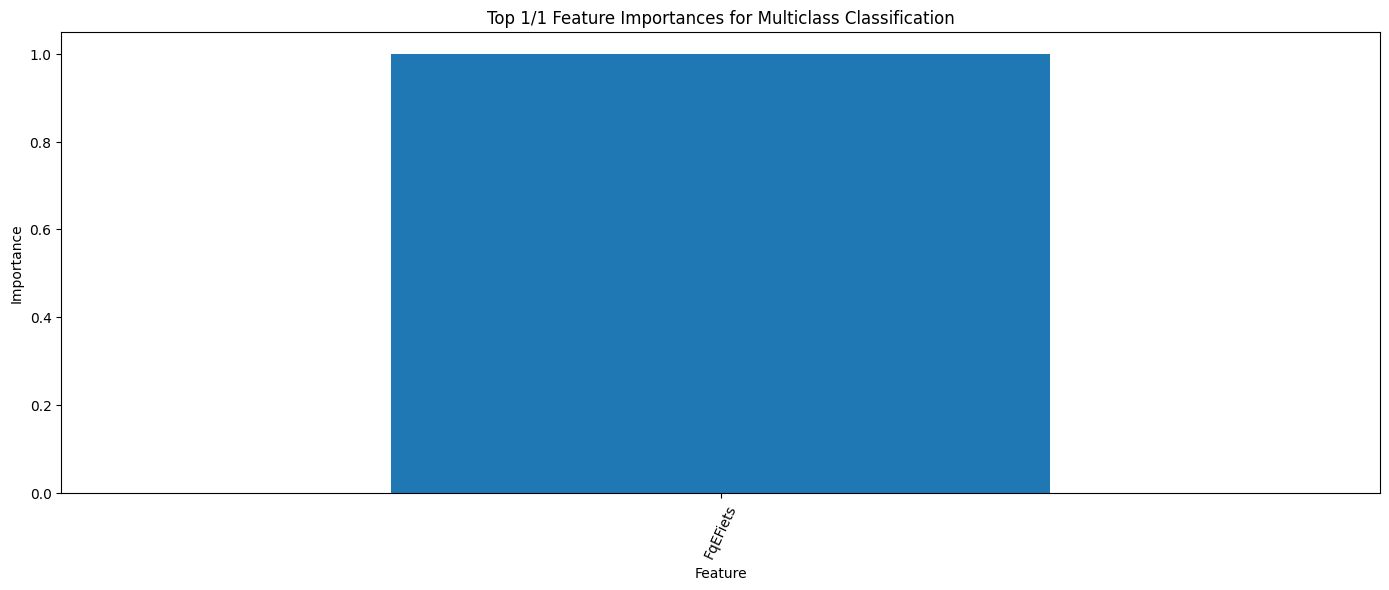

In [15]:
prev_grouped_importances = grouped_importances_less

nums = [200, 100, 50, 25, 15, 10, 8, 5, 4, 3, 2, 1]
accs = []
features_per_num = dict()

for num_keep in nums:
    prev_grouped_importances = prev_grouped_importances.sort_values(ascending=False)[:num_keep]

    cols_to_drop = [col for col in df_less_vehicles.columns if col not in list(prev_grouped_importances.index) + [transport_mode_col, id_col]]
    df_keep_loop = df_less_vehicles.drop(columns=cols_to_drop)
    print(f"Keeping {len(df_keep_loop.columns)} columns after dropping {len(cols_to_drop)} columns.")

    pipeline_keep_loop, (X_train, _, _, _), accuracy = run_multiclass_classification(
        df_keep_loop,
        test_size=0.2,
        destinations=None,
        origins=origins,
        location_level=location_level,
        categorical_features=categorical_cols,
        motives=motives,
        plot=True,
        savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles_{num_keep}",
        plot_title=f"Confusion Matrix for {origin_str} and {motive_str} using {num_keep} features",
        verbose=True,
    )


    prev_grouped_importances = get_feature_importances(
        pipeline_keep_loop["model"].feature_importances_, 
        column_names=X_train.columns, 
        top_n_for_plot=40, 
        savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles_{num_keep}.png"
    )
    accs.append(accuracy)

    features_per_num[num_keep] = prev_grouped_importances

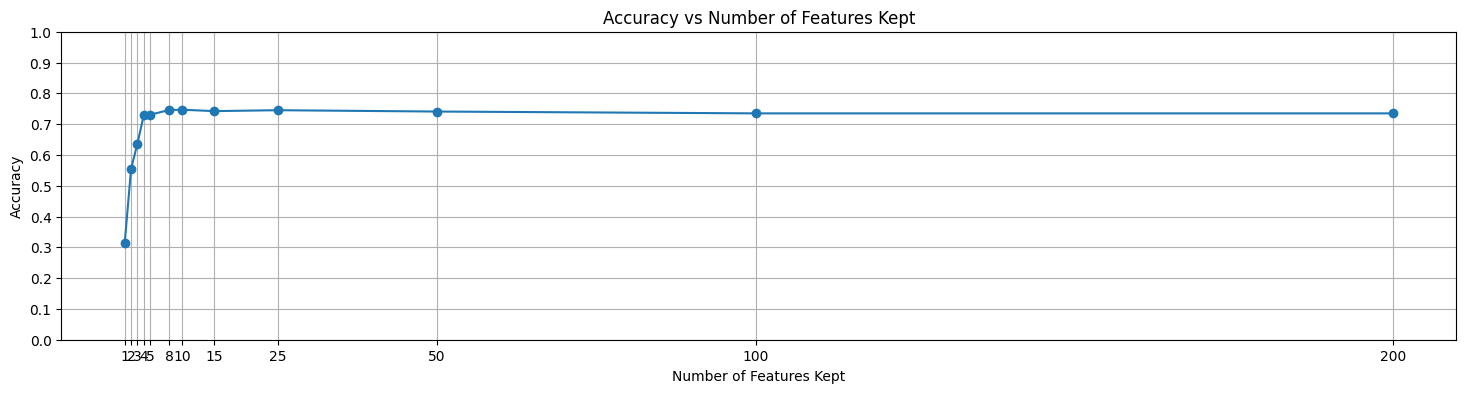

In [16]:
plt.figure(figsize=(18, 4))
plt.plot(nums, accs, marker='o')
plt.title("Accuracy vs Number of Features Kept")
plt.xlabel("Number of Features Kept")
plt.ylabel("Accuracy")
# plt.xscale('log')
plt.xticks(nums)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.savefig("graphics/classification_results/multiclass/accuracy_vs_num_features.png", dpi=300)
plt.show()

Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.92      0.72      0.80     70523
    Electric bicycle       0.43      0.90      0.58     10541
Non-electric bicycle       0.64      0.79      0.71     33669
             On foot       0.81      0.72      0.76     34802

            accuracy                           0.75    149535
           macro avg       0.70      0.78      0.71    149535
        weighted avg       0.80      0.75      0.76    149535



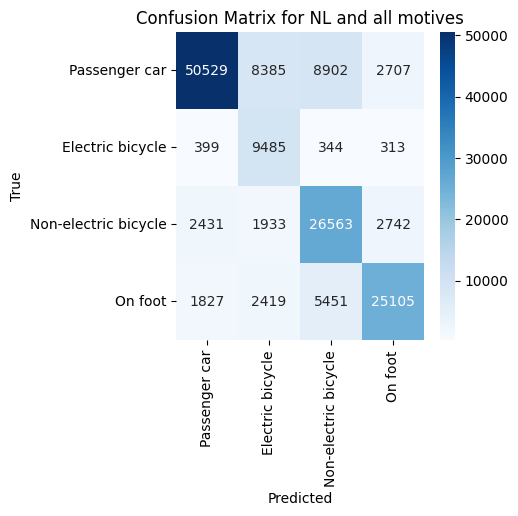

In [17]:
num_to_replicate = 10

# categorical_cols_for_small = [
#     urbanness_col, 
#     age_col,
#     distance_col,
#     motive_col,
#     "KAfstV",
#     "Doel"
# ] 

cols_to_keep = features_per_num[num_to_replicate].index.to_list() + [id_col]
cols_to_drop = [col for col in df_less_vehicles.columns if col not in cols_to_keep + [transport_mode_col]]

pipeline_transferable, (X_train, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    drop_cols=cols_to_drop,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/transferable_forest_{num_to_replicate}",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

In [127]:
from codebase import prepare_odin_stats, odin_add_buurtcode, punt_buurt_code_column
from codebase.classification.multiclass import run_transferable_classification

In [ ]:

def run_transferable_classification(
        odin_df: pd.DataFrame, 
        pipeline_transferable,
        cols_for_transferable, 
        necessary_columns,
        threshold_datapoints=100, 
        unused_target="a_inw",
        col_car_pred = "willingness_to_car_pred",
        col_cycle_pred = "willingness_to_cycle_pred",
        col_ebike_pred = "willingness_to_ebike_pred",
        col_walk_pred = "willingness_to_walk_pred",
        goal_value=7,
        motive_value=6,
        plot=True,
        df_save_path=None, 
        overwrite_existing=False,
    ):

    if df_save_path is None:
        df_save_path = f"data/classification_results/multiclass/transferable_classification_results_{goal_value}_{motive_value}_{threshold_datapoints}.csv"
    else:
        if not df_save_path.endswith(".csv"):
            df_save_path += ".csv"
        if os.path.exists(df_save_path) and not overwrite_existing:
            print(f"File {df_save_path} already exists. Loading existing results.")
            demographics_with_predictions = pd.read_csv(df_save_path)
            return demographics_with_predictions
    
    # Ensure the DataFrame has the necessary columns
    odin_df["BuurtCode"] = odin_df["WoPC"].astype(str)  
    odin_df[punt_buurt_code_column] = odin_df["BuurtCode"].astype(str)
    # Ensure the 'WoPC' column is present and format the 'BuurtCode' column for plotting later
    stats_df = prepare_odin_stats(odin_df, buurt_code_column="BuurtCode",)
    stats_df["WoPC"] = stats_df["BuurtCode"]
    stats_df = odin_add_buurtcode(stats_df, buurt_code_column="BuurtCode")
    stats_df[punt_buurt_code_column] = stats_df["BuurtCode"].apply(lambda x: "BU" + str(x)).astype(str)
    
    # Filter the DataFrame based on the threshold for the number of trips per BuurtCode 
    mask_count = stats_df["Count"] > threshold_datapoints
    demographics = stats_df[mask_count]
    # Set the goal and motive values
    demographics.loc[:, "Doel"] = goal_value         # Education
    demographics.loc[:, "KMotiefV"] = motive_value   # Education
    print(f"Contains {len(demographics)} rows with more than {threshold_datapoints} trips per BuurtCode.")
    demographics[unused_target] = 0
    # Make the categorical columns and remove the unused columns
    categorical_cols_for_transferable = [col for col in cols_for_transferable if col in categorical_cols]
    cols_to_drop_transferable = [col for col in demographics.columns if col not in cols_for_transferable + [unused_target, id_col]]
    # Turn the DataFrame into a machine learning dataset
    demographics_ml_X, _, _, _ = make_ml_dataset(
        demographics,
        target_col=unused_target,
        categorical_cols=categorical_cols_for_transferable,
        group_col=None,
        drop_cols=cols_to_drop_transferable,
        test_size=0.0001,
        ensure_common_labels=False
    )
    # Ensure the DataFrame has the necessary columns for the model
    demographics_ml_X = demographics_ml_X.dropna()
    missing_cols = set(necessary_columns) - set(demographics_ml_X.columns)
    for col in missing_cols:
        demographics_ml_X[col] = 0
    demographics_ml_X = demographics_ml_X[necessary_columns]

    # Predict the probabilities using the transferable model
    predicted_probs = pipeline_transferable.predict_proba(demographics_ml_X)
    # Create a DataFrame with the predictions
    demographics_ml_with_predictions = demographics_ml_X.copy()
    demographics_ml_with_predictions[transport_mode_col + "_pred"] = np.argmax(predicted_probs, axis=1)
    demographics_ml_with_predictions[col_car_pred] = predicted_probs[:, 0]  # Assuming index 0 corresponds to car
    demographics_ml_with_predictions[col_cycle_pred] = predicted_probs[:, 1]  # Assuming index 1 corresponds to cycling
    demographics_ml_with_predictions[col_ebike_pred] = predicted_probs[:, 2]  # Assuming index 2 corresponds to e-biking
    demographics_ml_with_predictions[col_walk_pred] = predicted_probs[:, 3]  # Assuming index 3 corresponds to walking

    demographics_with_predictions = demographics.copy()
    demographics_with_predictions = demographics_with_predictions.merge(
        demographics_ml_with_predictions[[transport_mode_col + "_pred", col_car_pred, col_cycle_pred, col_ebike_pred, col_walk_pred]],
        how="left",
        left_index=True,
        right_index=True
    )

    os.makedirs(os.path.dirname(df_save_path), exist_ok=True)
    demographics_with_predictions.to_csv(df_save_path, index=False)
    print(f"Saved predictions to {df_save_path}")
    
    if plot:
        for col in [col_car_pred, col_cycle_pred, col_ebike_pred, col_walk_pred]:
            plot_value_by_buurt_heatmap(
                demographics_with_predictions,
                col_name=col,
                # title=f"Willingness to {col.replace('willingness_to_', '').capitalize()} by Buurt according to Transferable Model",
                savename=f"graphics/classification_results/multiclass/transferable_{col}.png",
                show=plot
            )
    return demographics_with_predictions

Contains 3465 rows with more than 10 trips per BuurtCode.


C:\Users\toell\AppData\Local\Temp\ipykernel_29148\202092914.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics[unused_target] = 0
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


Saved predictions to data/classification_results/multiclass/transferable_classification_results_7_6_10.csv


<Figure size 1000x1000 with 0 Axes>

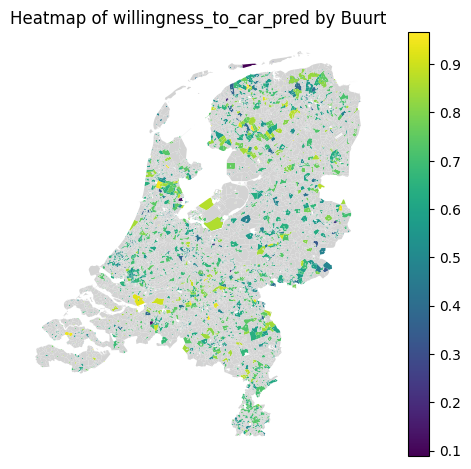

<Figure size 1000x1000 with 0 Axes>

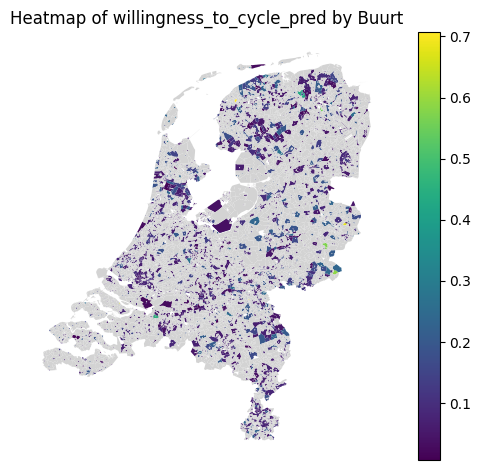

<Figure size 1000x1000 with 0 Axes>

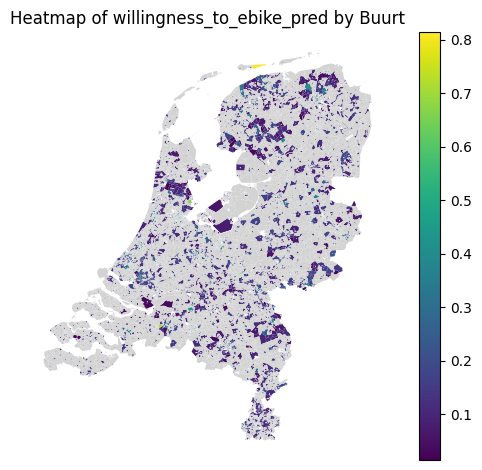

<Figure size 1000x1000 with 0 Axes>

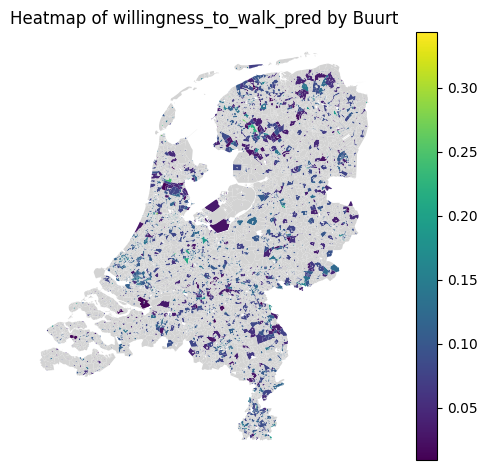

,BuurtCode,ActDuur,Leeftijd,AantVpl,AantOVVpl,AantSVpl,FactorH,FactorP,FactorV,HHPers,...,Count,WoPC,bu_code,a_inw,Hvm_pred,willingness_to_car_pred,willingness_to_cycle_pred,willingness_to_ebike_pred,willingness_to_walk_pred,buurtcode
0,0363AF01,91.749280,44.890490,4.325648,0.190202,0.048991,219.515746,336.926941,123037.446658,2.066282,...,347,1011,BU0363AF01,0,2.0,0.365602,0.061589,0.397732,0.175077,BU0363AF01
1,0363AD01,98.785088,37.513158,4.000000,0.491228,0.000000,276.500259,337.039560,123075.080375,1.429825,...,228,1012,BU0363AD01,0,2.0,0.370228,0.060417,0.395856,0.173500,BU0363AD01
2,0363AA03,93.164049,43.748691,3.945899,0.204188,0.041885,200.791008,334.767039,122243.738127,2.279232,...,573,1013,BU0363AA03,0,0.0,0.446655,0.058257,0.347271,0.147817,BU0363AA03
3,0363EB02,99.925000,40.166667,4.608333,0.066667,0.000000,203.099576,318.988890,116457.395591,2.475000,...,120,1014,BU0363EB02,0,0.0,0.624420,0.071320,0.218176,0.086084,BU0363EB02
4,0363AC01,93.791150,46.056637,4.598230,0.253097,0.012389,198.018681,301.548195,110129.811750,2.047788,...,565,1015,BU0363AC01,0,0.0,0.521733,0.049903,0.297310,0.131055,BU0363AC01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3867,19660902,91.744186,50.976744,3.953488,0.116279,0.023256,147.503259,324.038347,118352.616822,2.732558,...,86,9989,BU19660902,0,0.0,0.648220,0.170124,0.104098,0.077559,BU19660902
3868,19791881,123.452830,43.452830,3.603774,0.150943,0.000000,183.067108,309.691708,113107.034995,2.509434,...,53,9991,BU19791881,0,0.0,0.751841,0.061362,0.112828,0.073970,BU19791881
3872,19661001,88.529412,50.588235,5.352941,0.352941,0.000000,138.154368,341.185708,124532.783338,3.294118,...,17,9995,BU19661001,0,0.0,0.903495,0.058320,0.021358,0.016827,BU19661001
3873,19661003,93.791667,42.166667,3.333333,0.000000,0.125000,146.944392,274.022213,100018.107904,2.416667,...,24,9997,BU19661003,0,0.0,0.542729,0.244590,0.128844,0.083837,BU19661003


In [137]:
cols_for_transferable = features_per_num[num_to_replicate].index.to_list()

run_transferable_classification(
    odin_df=df_all,
    pipeline_transferable=pipeline_transferable,
    cols_for_transferable=cols_for_transferable,
    necessary_columns=X_train.columns,
    col_car_pred = "willingness_to_car_pred",
    col_cycle_pred = "willingness_to_cycle_pred",
    col_ebike_pred = "willingness_to_ebike_pred",
    col_walk_pred = "willingness_to_walk_pred",
    threshold_datapoints=10,
)

In [98]:
df_all["BuurtCode"] = df_all["WoPC"].astype(str)  
df_all[punt_buurt_code_column] = df_all["BuurtCode"].astype(str)  
stats_df = prepare_odin_stats(df_all, buurt_code_column="BuurtCode",)

In [102]:
stats_df["WoPC"] = stats_df["BuurtCode"]
stats_df = odin_add_buurtcode(stats_df, buurt_code_column="BuurtCode")
stats_df[punt_buurt_code_column] = stats_df["BuurtCode"].apply(lambda x: "BU" + str(x)).astype(str)

In [111]:
mask_count = stats_df["Count"] > 100
demographics = stats_df[mask_count]
demographics.loc[:, "Doel"] = 7       # Education
demographics.loc[:, "KMotiefV"] = 6   # Education
print(len(demographics))

2076


In [ ]:
from codebase import make_ml_dataset

cols_for_transferable = features_per_num[num_to_replicate].index.to_list()
print(f"Columns for transferable model: {cols_for_transferable}")
print(demographics[punt_buurt_code_column].head())

unused_target = "a_inw" 
demographics[unused_target] = 0

categorical_cols_for_transferable = [col for col in cols_for_transferable if col in categorical_cols]
cols_to_drop_transferable = [col for col in demographics.columns if col not in cols_for_transferable + [unused_target, id_col]]

demographics_ml_X, _, _, _ = make_ml_dataset(
    demographics,
    target_col=unused_target,
    categorical_cols=categorical_cols_for_transferable,
    group_col=None,
    drop_cols=cols_to_drop_transferable,
    test_size=0.0001,
    ensure_common_labels=False
)

demographics_ml_X = demographics_ml_X.dropna()
missing_cols = set(X_train.columns) - set(demographics_ml_X.columns)
for col in missing_cols:
    demographics_ml_X[col] = 0
demographics_ml_X = demographics_ml_X[X_train.columns]

Columns for transferable model: ['AfstV', 'AfstandOP', 'Doel', 'FqAutoB', 'FqEFiets', 'FqNEFiets', 'HHEFiets', 'KAfstV', 'KMotiefV', 'MotiefV']
0    BU0363AF01
1    BU0363AD01
2    BU0363AA03
3    BU0363EB02
4    BU0363AC01
Name: bu_code, dtype: object


In [ ]:
col_car_pred = "willingness_to_car_pred"
col_cycle_pred = "willingness_to_cycle_pred"
col_ebike_pred = "willingness_to_ebike_pred"
col_walk_pred = "willingness_to_walk_pred"

predicted_probs = pipeline_transferable.predict_proba(demographics_ml_X)

demographics_ml_with_predictions = demographics_ml_X.copy()
demographics_ml_with_predictions[transport_mode_col + "_pred"] = np.argmax(predicted_probs, axis=1)
demographics_ml_with_predictions[col_car_pred] = predicted_probs[:, 0]  # Assuming index 0 corresponds to car
demographics_ml_with_predictions[col_cycle_pred] = predicted_probs[:, 1]  # Assuming index 1 corresponds to cycling
demographics_ml_with_predictions[col_ebike_pred] = predicted_probs[:, 2]  # Assuming index 2 corresponds to e-biking
demographics_ml_with_predictions[col_walk_pred] = predicted_probs[:, 3]  # Assuming index 3 corresponds to walking

demographics_with_predictions = demographics.copy()
demographics_with_predictions = demographics_with_predictions.merge(
    demographics_ml_with_predictions[[transport_mode_col + "_pred", col_car_pred, col_cycle_pred, col_ebike_pred, col_walk_pred]],
    how="left",
    left_index=True,
    right_index=True
)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


['BU00140000' 'BU00140001' 'BU00140002' ... 'BU19923202' 'BU19923209'
 'BU19923300']


<Figure size 1000x1000 with 0 Axes>

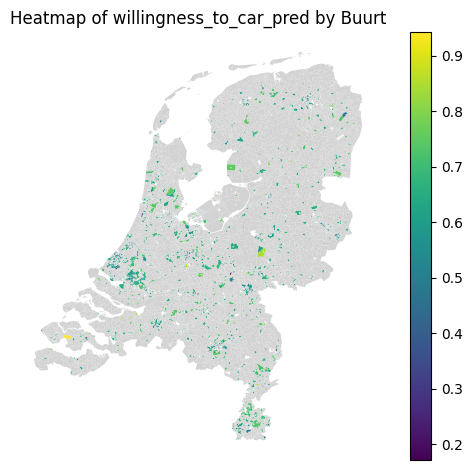

['BU00140000' 'BU00140001' 'BU00140002' ... 'BU19923202' 'BU19923209'
 'BU19923300']


<Figure size 1000x1000 with 0 Axes>

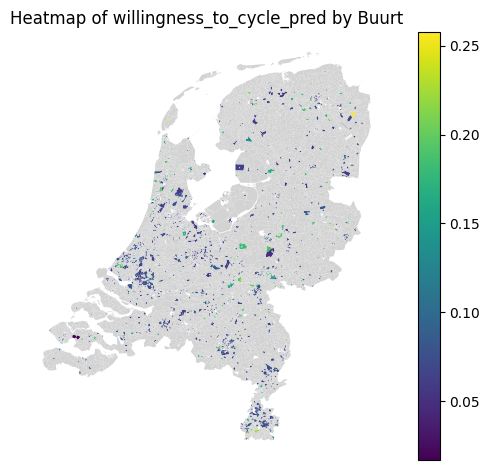

['BU00140000' 'BU00140001' 'BU00140002' ... 'BU19923202' 'BU19923209'
 'BU19923300']


<Figure size 1000x1000 with 0 Axes>

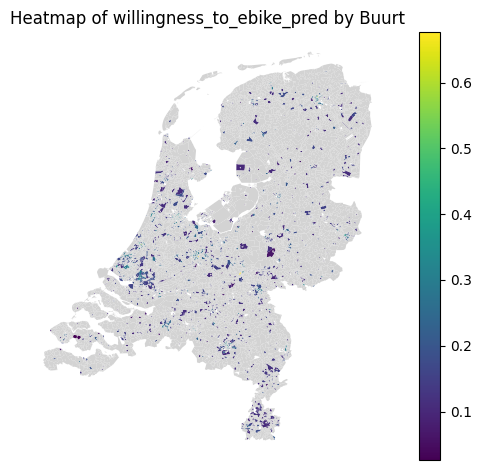

['BU00140000' 'BU00140001' 'BU00140002' ... 'BU19923202' 'BU19923209'
 'BU19923300']


<Figure size 1000x1000 with 0 Axes>

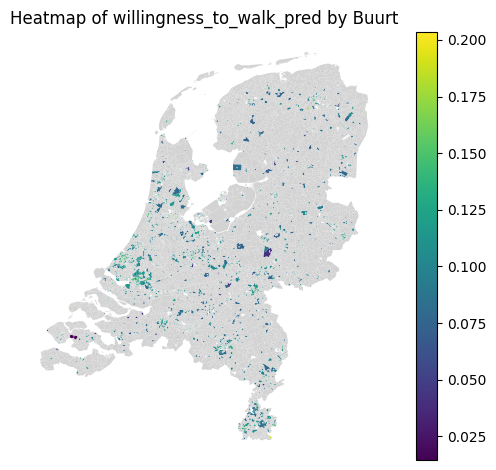

In [118]:
from codebase import plot_value_by_buurt_heatmap

for col in [col_car_pred, col_cycle_pred, col_ebike_pred, col_walk_pred]:
    plot_value_by_buurt_heatmap(
        demographics_with_predictions,
        col_name=col,
        # title=f"Willingness to {col.replace('willingness_to_', '').capitalize()} by Buurt according to Transferable Model",
        savename=f"graphics/classification_results/multiclass/transferable_{col}.png",
    )
    plt.show()

<Figure size 1000x1000 with 0 Axes>

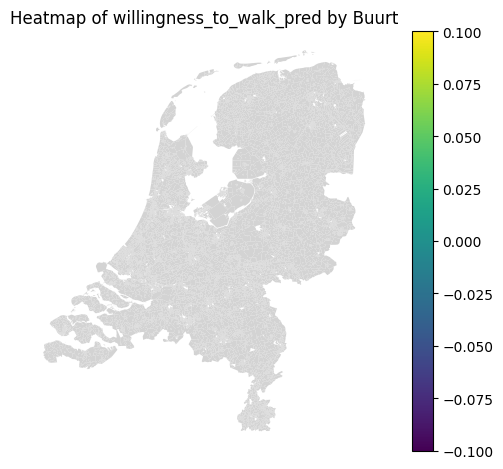

In [ ]:
plot_value_by_buurt_heatmap(
        demographics_with_predictions,
        col_name=col,
        # title=f"Willingness to {col.replace('willingness_to_', '').capitalize()} by Buurt according to Transferable Model",
        savename=f"graphics/classification_results/multiclass/transferable_{col}.png",
    )